In [1]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()

from taurex.model import TransmissionModel
from taurex.planet import Planet
from taurex.stellar import BlackbodyStar
from taurex.chemistry import TaurexChemistry, ConstantGas
from taurex.temperature import Guillot2010

Numba not installed, using numpy instead


In [2]:
#cross-sections

from taurex.cache import OpacityCache,CIACache

OpacityCache().clear_cache()
OpacityCache().set_opacity_path("/home/silvia/Desktop/Magistrale/Esami_da_dare/Computational_astrophysics/Taurex/data/xsecs")
CIACache().set_cia_path("/home/silvia/Desktop/Magistrale/Esami_da_dare/Computational_astrophysics/Taurex/data/cia/hitran")




In [3]:
# Define the planetary parameters
planet_radius = 1.27  # Jupiter radii
planet_mass = 0.46       #Jupyter masses
star_radius = 0.79    # Solar radii
T_irr = 1200.0        # Irradiation temperature (K)
T_star = 5000.0       # Stellar temperature (K)

# Create temperature profile
guillot = Guillot2010(T_irr=T_irr)

# Create a planet instance
planet = Planet(planet_radius=planet_radius, planet_mass=planet_mass)  

# Create a star instance
star = BlackbodyStar(temperature=T_star, radius=star_radius)

In [4]:
chemistry = TaurexChemistry()
# Define and randomize gas abundances for H2O, CH4, CO2, and CO
gases = ['H2O', 'CH4', 'CO2', 'CO']


for gas_name in gases:
    abundance = 10**np.random.uniform(-8, -3)  # Randomize abundance within the specified range
    chemistry.addGas(ConstantGas(gas_name, mix_ratio=abundance))
    print(gas_name, abundance)

H2O 1.1849268472844524e-08
CH4 0.0006701698706893773
CO2 0.00019346042160717984
CO 4.156131291171863e-06


In [5]:
guillot = Guillot2010(T_irr=1200.0)

guillot.T_irr

1200.0

In [6]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet, chemistry=chemistry, star=star, atm_min_pressure=1e-0, atm_max_pressure=1e6, nlayers=30)#, temperature_profile=guillot)

In [7]:
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

In [8]:
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

In [9]:
tm.build()

res = tm.model()
res

(array([  199.99326855,   200.00660143,   200.01993521, ...,
        33328.88933329, 33331.11125925, 33333.33333333]),
 array([0.03122821, 0.03210747, 0.03083464, ..., 0.03113226, 0.03113242,
        0.03113258]),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         4.50708363e-239, 3.84115096e-239, 3.27345294e-239],
        [1.92094579e-239, 4.82902034e-233, 7.36352238e-209, ...,
         5.48664318e-152, 4.95726260e-152, 4.47882182e-152],
        ...,
        [9.95906186e-001, 9.58256544e-001, 9.97819540e-001, ...,
         9.96467634e-001, 9.96466606e-001, 9.96465579e-001],
        [9.97628548e-001, 9.76156126e-001, 9.98759939e-001, ...,
         9.98029467e-001, 9.98028893e-001, 9.98028320e-001],
        [9.98961046e-001, 9.89717055e-001, 9.99458968e-001, ...,
         9.99145148e-001, 9.99144900e-001, 9.99144651e-001]]),
 None)

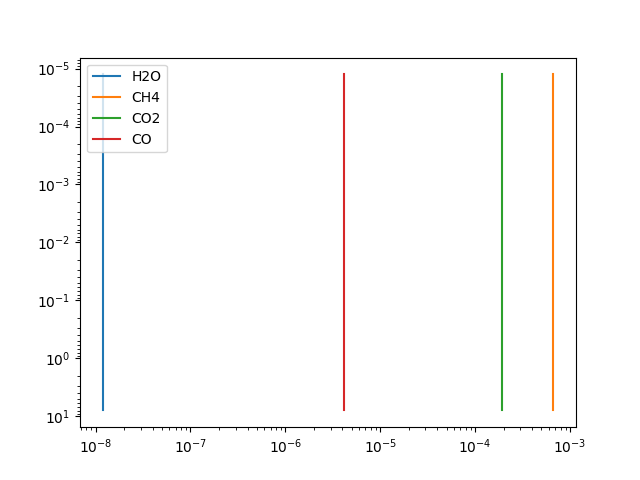

In [10]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
#for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
 #   plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

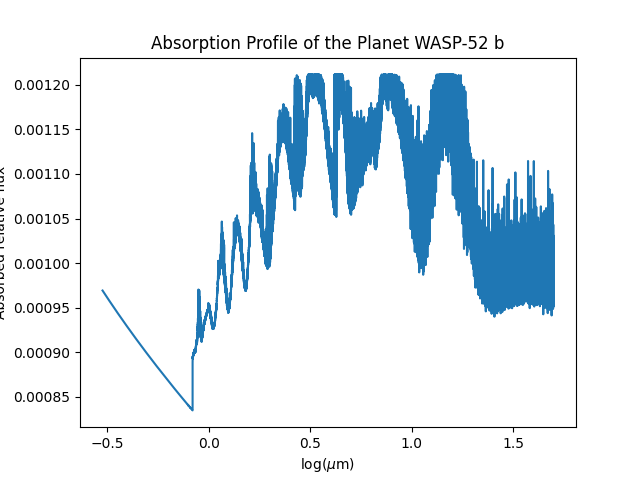

In [11]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs**2) #in micrometers, absorptio
#plt.plot((native_grid)**-1,rprs)
plt.title('Absorption Profile of the Planet WASP-52 b')
plt.xlabel('log($\mu$m)')
#plt.xlim([2.5,5.1])
plt.ylabel('Absorbed relative flux')
plt.show()

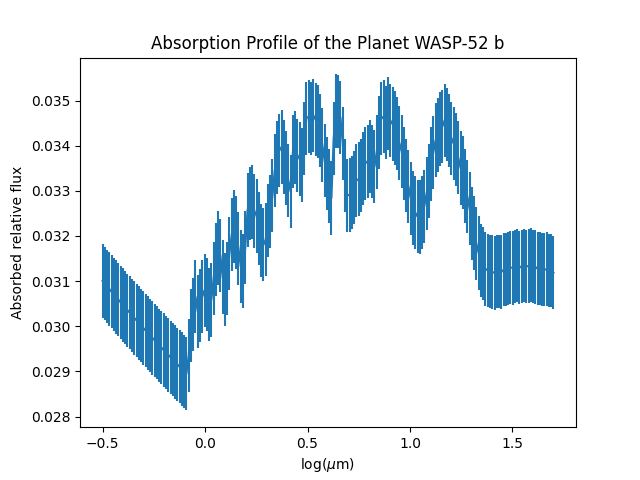

In [12]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.5,1.7,200))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

error=np.std(bin_rprs)/2

plt.errorbar(np.log10(10000/bin_wn), bin_rprs, error)
#plt.xscale('log')
plt.title('Absorption Profile of the Planet WASP-52 b')
plt.xlabel('log($\mu$m)')
#plt.xlim([2.5,5.1])
plt.ylabel('Absorbed relative flux')
plt.show()



In [13]:
# Convert the native grid (wavenumber) to wavelength in microns
wavelength = 10000 / native_grid  # Convert from cm^-1 to microns

# Calculate (Rp/Rs)^2 and sqrt((Rp/Rs)^2)
rprs_squared = bin_rprs
rprs_sqrt = [error]*len(bin_rprs)

print(np.shape(rprs_sqrt))

# Combine the data into a single array
spectrum_data = np.column_stack((10000/bin_wn , rprs_squared, rprs_sqrt))



# Extract the active gases and their abundances
gases = tm.chemistry.activeGases
abundances = tm.chemistry.activeGasMixProfile[:, 0]  # Assuming column 0 contains the relevant abundances

# Format the gases and abundances into a string
gases_header = ", ".join([f"{gas}: {abundance:.2e}" for gas, abundance in zip(gases, abundances)])

# Create the header
header = f"Wavelength(micron) (Rp/Rs)^2 sqrt((Rp/Rs)^2), Gases and abundances: {gases_header}"


# Save the data to a file
planet_name = "WASP-52b"  # Replace with your planet's name
file_name = f"{planet_name}_assignment3_taskA_spectrum_prova.dat"
np.savetxt(file_name, spectrum_data, header=header, fmt="%.6e")

print(f"Spectrum saved to {file_name}")

(200,)
Spectrum saved to WASP-52b_assignment3_taskA_spectrum_prova.dat


In [14]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'CH4',
 'CO2',
 'CO',
 'He_H2']

In [15]:
# Assuming `model` is your TAU-REx in
print('planet mass: ', tm.planet.get_planet_mass())
print('planet radius: ', tm.planet.get_planet_radius())
#print('planet temperature: ', tm.planet.)
print('star temperature: ', tm.star.temperature)
print('gasses present: ', tm.chemistry.activeGases)
print('gasses abundances: ', tm.chemistry.activeGasMixProfile[:,0])



planet mass:  0.4600000000000001
planet radius:  1.27
star temperature:  5700.0
gasses present:  ('H2O', 'CH4', 'CO2', 'CO')
gasses abundances:  [1.18492685e-08 6.70169871e-04 1.93460422e-04 4.15613129e-06]
